**Simulating a chemostat and crossfeeding with COMETS**

COMETS provides the functionality to run simulations in a chemostat. Here, we use the python toolbox to generate a chemostat simulation in two ways. 1) by manually assigning all the "parts," and 2) by using a helper function we've included.

Here we are going to simulate a chemostat with lactose as the sole carbon resource and two strains of E. coli: one which is defiicient in the ability to uptake lactose, and one which is deficient in the ability to metabolize galactose. We will use the ijo1366 model provided as part of cobrapy. Let's first do the imports.

In [39]:
import cobra
import cobra.test # for the ijo1366 model
import sys
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/COMETS-Python-Toolbox")
import comets as c

Now let's load the ijo1366 model, make a copy, and knockout the relevant reactions.

Note that the first model had galE knocked out to prevent metabolism of galactose, which will cause galactose to be secreted during metabolism of lactose. The second model had a reaction knocked out instead of a gene, as lactose transport to the periplasm can be accomplished with multiple genes, and so it is simpler to juts knockout the reaction itself.

In [40]:
E_no_galE = cobra.test.create_test_model("ecoli") # this model will have galE KO'd
E_no_LCTStex = E_no_galE.copy() # this model will have lactose uptake KO'd
E_no_galE.genes.b0759.knock_out()
E_no_LCTStex.reactions.LCTStex.knock_out()

We can test that the knockouts perform as expected by trying to grow them in media containing lactose and galactose. We do this in cobrapy.

In [41]:
medium = E_no_galE.medium
medium["EX_glc__D_e"] = 0.
medium["EX_lcts_e"] = 1.
medium["EX_gal_e"] = 1.
print(medium)
E_no_galE.medium = medium
E_no_LCTStex.medium = medium
# examine growth and uptake in the galE knockout shows galactose is excreted
print("\n\nE_no_galE uptakes lactose and excrete galactose: ")
E_no_galE.summary()

{'EX_ca2_e': 1000.0, 'EX_cbl1_e': 0.01, 'EX_cl_e': 1000.0, 'EX_co2_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0, 'EX_glc__D_e': 0.0, 'EX_h_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_k_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_na1_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_ni2_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_sel_e': 1000.0, 'EX_slnt_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_tungs_e': 1000.0, 'EX_zn2_e': 1000.0, 'EX_lcts_e': 1.0, 'EX_gal_e': 1.0}


E_no_galE uptakes lactose and excrete galactose: 


In [42]:
print("\n\nE_no_LCTStex uptakes galactose but not lactose: ")
E_no_LCTStex.summary()



E_no_LCTStex uptakes galactose but not lactose: 


Now that we are satisfied we have made our models correctly, we can setup a COMES simulation. Let's intend that the medium above is the reservoir medium (except that we will remove galactose first), and that the input rate and output rate are 10% per hour. Here, let's set dilution rate parameter, the initial population size (in gDW), and generate the COMETS models. 

Whenever we make COMETS models from COBRA models, we almost always want to set the exchange lower bounds to -1000 so that COMETS can alter these based upon media concentrations.

Finally, right now both models have the same ID, which will confuse COMETS, so we must give them unique IDs.

In [43]:
# chemostat parameters
dilution_rate = 0.1 # / hr
initial_pop = 1.e-3 # gDW

# make COMETS models from the cobrapy models
E_no_galE.id = "galE_KO"
E_no_LCTStex.id = "LCTStex_KO"

galE_comets = c.model(E_no_galE)
galE_comets.initial_pop = [0,0,initial_pop] # x, y, gDW
galE_comets.reactions.loc[galE_comets.reactions.EXCH, "LB"] = -1000

lcts_comets = c.model(E_no_LCTStex)
lcts_comets.initial_pop = [0,0,initial_pop] # x, y, gDW
lcts_comets.reactions.loc[lcts_comets.reactions.EXCH, "LB"] = -1000

Now we are going to use the manual method for making a chemostat. Recall that cobrapy media are set using exchange reaction IDs, whereas COMETS media are set using metabolite ids. We can easily take care of this difference with a dictionary comprehension. Here we do that, then generate a layout, and add the media components to that layout.

In [44]:
# setup layout by providing models
layout = c.layout([galE_comets, lcts_comets])

# re-write media (while removing galactose) and add it to layout
comets_media = {key[3:]: value for key, value in medium.items() if key != "EX_gal_e"}
for key, value in comets_media.items():
    layout.set_specific_metabolite(key, value)

The input of fresh media from the reservoir into the simulation is done using media_refresh. Metabolites with a media_refresh value are replenished at the specified amount per-hour. Since we are diluting at 0.1 per hour, we multiply the reservoir concentration by this rate.

In [45]:
for key, value in comets_media.items():
    layout.set_specific_refresh(key, value * dilution_rate)

The rest of the chemostat--the outflow--is setup in the parameters using metaboliteDilutionRate and deathRate. These should be set equal to the desired dilution rate. Here we generate a parameters object and set these values.

In [46]:
params = c.params()
params.all_params["deathRate"] = dilution_rate
params.all_params["metaboliteDilutionRate"] = dilution_rate

Let's also adjust a few other parameters.

In [47]:
params.all_params["timeStep"] = 0.1 # hours
params.all_params["maxSpaceBiomass"] = 10. # gDW
params.all_params["maxCycles"] = 2000 # duration of simulation in time steps

Finally, let's keep track of two key metabolites: lactose and galactose. We do this using the specificMedia log, and choosing the metabolites with a comma-separated string with no spaces.

In [48]:
params.all_params["writeSpecificMediaLog"] = True
params.all_params["specificMediaLogRate"] = 1 # time steps
params.all_params["specificMedia"] = "lcts_e,gal_e" # metabolites to track

Now the chemostat aspects are setup using the layout and the parameters. Therefore, we can generate a COMETS simulation, run it, and then examine the biomass and metabolites.

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha

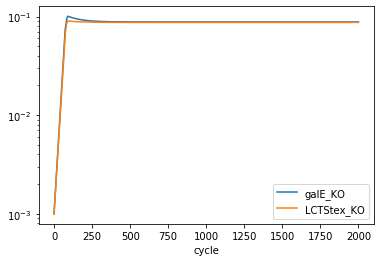

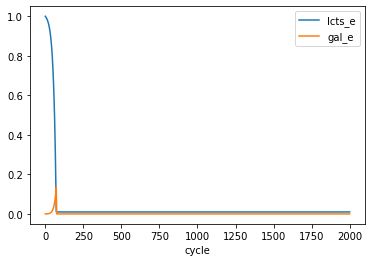

In [49]:
sim = c.comets(layout, params)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.8.2.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.run()

Now let's plot the results. Note how we specify the axes, otherwise "cycle", "x", and "y" will be assumed to be state variables. 

What we see is that both species survive, because the LCTStex_KO cross-feeds galactose from the galE_KO, which uses the glucose piece of lactose. The metabolites, as is typical in a chemostat, are in very low concentrations once equilibrium is reached.

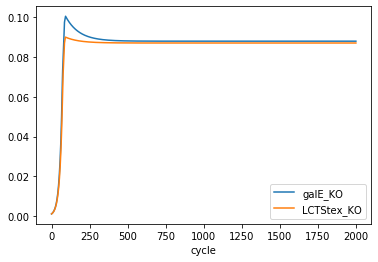

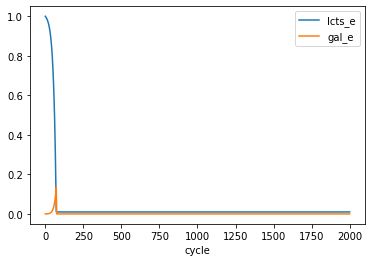

In [51]:
sim.total_biomass.plot(x = "cycle")
sim.specific_media.plot(x = "cycle",y = ["lcts_e","gal_e"])

The above code required setting chemostat parameters in multiple places. We offer this functionality so that researchers can create complex setups that may, for example, have different initial concentrations than reservoir concentrations, and different inflow rates than outflow rates. However, we expect most chemostat simulations will function like abbove, where a single dilution parameter dictates the behavior of the system. For this typical use-case, we have made a helper function which generates a layout and parameters objects with the correct setup.

In [ ]:
layout, params = c.chemostat([galE_comets, lcts_comets], comets_media, dilution_rate)
# we can still adjust the parameters as desired.
params.all_params["timeStep"] = 0.1 # hours
params.all_params["maxSpaceBiomass"] = 10. # gDW
params.all_params["maxCycles"] = 2000 # duration of simulation in time steps
params.all_params["writeSpecificMediaLog"] = True
params.all_params["specificMediaLogRate"] = 1 # time steps
params.all_params["specificMedia"] = "lcts_e,gal_e" # metabolites to track
# then we make the simulation object and run as before
sim = c.comets(layout, params)
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.8.2.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.run()
sim.total_biomass.plot(x = "cycle")

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha